In [47]:
import pandas as pd
import numpy as np
import os
import joblib
import itertools
import shared_functions
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, ensemble, metrics
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

data_path = 'data/projects_for_test'
test_srr_info1 = 'data/projects_for_test/PMID32078625_metadata.csv'
test_srr_info2 = 'data/projects_for_test/PRJNA493726_metadata.csv'

In [48]:
bf = joblib.load('joblib/catsNdogs_mw_bf.joblib')

## Load cats and dogs test projects

In [49]:
cd_test_projects = ['PRJNA592436_f1','PRJNA589580_f1','PRJNA401442','PMID32078625_f1','PRJNA470724_f1']
projects = [os.path.join(data_path, p) for p in cd_test_projects]
#print(projects)
projects_name = [ele.replace('_f1','') for ele in cd_test_projects]
data = shared_functions.read_data_set(zip(projects, projects_name),1)
data.index = [ele.replace('_1','') for ele in data.index]
data.index = [ele.replace('_L001_R1_001','') for ele in data.index]
data['Host_type'] = 'pet'
z = pd.read_csv(test_srr_info1,sep=';')
#display(z.head())
z.set_index('sample_name',inplace=True)
dz = data.merge(z,how='left',left_index=True,right_index=True)
dz['DESCRIPTION'] = dz.DESCRIPTION.apply(str)
dz['Host'] = dz.apply(lambda x: 'Canis familiaris' if (x.DESCRIPTION=='nan') 
                      else ('Canis familiaris' if (x.DESCRIPTION=='Dog feces')
                            else 'Felis catus'),axis=1)
dz['Host'] = dz.apply(lambda x: 'Felis catus' if (x.project_name == 'PRJNA470724') else x.Host,axis=1)
dz.drop('DESCRIPTION',axis=1,inplace=True)
dz['project_name2'] = dz.apply(lambda x: x.project_name+'_dog' if (x.Host=='Canis familiaris')
                              else x.project_name+'_cat',axis=1)
print(dz.shape)
print(dz.project_name.value_counts())
print(dz.project_name2.value_counts())
cd_test_data = dz

(432, 289)
PMID32078625    238
PRJNA470724      74
PRJNA401442      56
PRJNA589580      35
PRJNA592436      29
Name: project_name, dtype: int64
PMID32078625_dog    192
PRJNA470724_cat      74
PRJNA401442_dog      56
PMID32078625_cat     46
PRJNA589580_dog      35
PRJNA592436_dog      29
Name: project_name2, dtype: int64


## Load human test projects

In [50]:
human_test_projects = ['PRJNA493726_f1','PRJNA385551_f1']
projects = [os.path.join(data_path, p) for p in human_test_projects]
projects_name = [ele.replace('_f1','') for ele in human_test_projects]
data = shared_functions.read_data_set(zip(projects, projects_name),1)
data.index = [ele.replace('_1','') for ele in data.index]
data['Host_type'] = 'human'
data['Host'] = 'Homo sapiens'
z = pd.read_csv(test_srr_info2,sep=',').loc[:,['Run','SampleName']]
z.set_index('Run',inplace=True)
dz = data.merge(z,how='left',left_index=True,right_index=True)
dz['SampleName'] = dz.SampleName.apply(str)
dz['SampleName'] = dz.SampleName.apply(lambda x: x.split('.')[0])
dz['health'] = dz.apply(lambda x: 'HC' if (x.SampleName=='nan') 
                        else x.SampleName,axis=1)
dz['project_name2'] = dz.project_name+'_'+dz.health
dz.drop(['SampleName','health'],axis=1,inplace=True)
print(dz.shape)
print(dz.project_name.value_counts())
print(dz.project_name2.value_counts())
human_test_data = dz

(358, 279)
PRJNA385551    284
PRJNA493726     74
Name: project_name, dtype: int64
PRJNA385551_HC     284
PRJNA493726_SLE     37
PRJNA493726_HC      19
PRJNA493726_RA      18
Name: project_name2, dtype: int64


In [51]:
pt = shared_functions.projects_table(pd.concat([human_test_data,cd_test_data]))
pt = pt.sort_values(['Host_type','Host','Samples #'],ascending=False)
pt.to_csv('results/catsNdogs_Table1_2.txt',sep='\t')

In [52]:
df = pd.concat([cd_test_data,human_test_data])
test_data = shared_functions.mydata(taxa_df = df.drop(['mean_chao','Host','Host_type','project_name','project_name2'],axis=1),
                               chao_df = df['mean_chao'],
                               info_df = df.loc[:,['Host','Host_type','project_name','project_name2']])

## Models accuracy on test data

In [53]:
def test_each_project(pr_col):
    levels = [5]
    features = ['all','best_holm','best_fdr']
    clr_b = [False,True]
    res_list = []
    scores_for_hist = {}
    for level,features,clr_b in itertools.product(levels, features, clr_b):
        view_name = shared_functions.view_name(level,features,clr_b)
        filename = shared_functions.make_name(level,features,clr_b,True)
        rf = joblib.load('joblib/'+filename)
        f,chao = bf[(level,features)]
        tf = shared_functions.transformer(bf=f,chao=chao,level=level,clr_b=clr_b)
        ti = test_data.info
        tps = pd.unique(ti[pr_col])
        scores_list={}
        for tp in tps:
            dt = ti[ti[pr_col]==tp]
            ht = pd.unique(dt.Host_type)[0]
            hosts = pd.unique(dt.Host)
            host = hosts[0]
            if (len(hosts)>1):
                host = 'cat+dog'
            taxa_df,chao_df,y = test_data.get_data_from_ind(dt.index,level,False)
            X = tf.transform_df(taxa_df,chao_df)
            y_predict = rf.predict(X)
            y_scores = rf.predict_proba(X).transpose()[1]
            acc = metrics.accuracy_score(y,y_predict)
            acc_str = '%.3f' % acc
            res_d = {'model_name':view_name,'test_project':tp,'Host_type':ht,'Host':host,'accuracy':acc_str}
            res_list.append(res_d)
            scores_list[tp]=y_scores
        scores_for_hist[view_name] = scores_list
    return(pd.DataFrame(res_list),scores_for_hist)

In [54]:
res2,h2 = test_each_project('project_name2')
res,h = test_each_project('project_name')
res = pd.concat([res,res2[(res2.test_project.str.contains('PRJNA493726')|res2.test_project.str.contains('PMID32078625'))]])
t5_acc = res.pivot_table(index=['model_name'], columns=['Host_type','Host','test_project'],values='accuracy',aggfunc='first').reset_index()
t5_acc.to_csv('results/catsNdogs_SupplementaryTable5.txt',sep='\t')
t5_acc

Host_type            model_name        human                             \
Host                            Homo sapiens                              
test_project                     PRJNA385551 PRJNA493726 PRJNA493726_HC   
0                     Genus_ALL        1.000       0.946          1.000   
1                 Genus_ALL_CLR        1.000       0.946          1.000   
2                  Genus_MW-FDR        1.000       0.932          1.000   
3              Genus_MW-FDR_CLR        1.000       0.905          1.000   
4                 Genus_MW-Holm        0.993       0.811          0.947   
5             Genus_MW-Holm_CLR        0.993       0.865          0.947   

Host_type                                                pet              \
Host                                        Canis familiaris               
test_project PRJNA493726_RA PRJNA493726_SLE PMID32078625_dog PRJNA401442   
0                     0.944           0.919            0.995       1.000   
1                     0.944           0.919            0.979       1.000   
2                     1.000           0.865            0.995       1.000   
3                     1.000           0.811            0.995       1.000   
4                     0.833           0.730            0.995       1.000   
5                     0.889           0.811            0.964       1.000   

Host_type                                                                       
Host                                      Felis catus                  cat+dog  
test_project PRJNA589580 PRJNA592436 PMID32078625_cat PRJNA470724 PMID32078625  
0                  1.000       1.000            0.913       1.000        0.979  
1                  1.000       1.000            0.783       0.986        0.941  
2                  1.000       1.000            0.935       0.973        0.983  
3                  1.000       1.000            0.957       0.973        0.987  
4                  1.000       1.000            0.978       1.000        0.992  
5                  0.971       1.000            0.957       1.000        0.962

In [55]:
t5_1 = t5_acc[t5_acc.model_name=='Genus_MW-FDR'].drop('model_name',axis=1).transpose()
t5_1.columns = ['accuracy']
t5_1.sort_index(level = ['Host_type','test_project'],inplace=True)
t5_1['samples #']=t5_1.index.to_series().apply(lambda x: len(h2['Genus_MW-FDR'][x[2]]) if (x[2] in h2['Genus_MW-FDR']) else len(h['Genus_MW-FDR'][x[2]]))
t5_1.to_csv('results/catsNdogs_Table3.txt',sep='\t')

# Figure 5

In [56]:
# 1) cats, dogs, humans
# scores2 = h2['Genus_MW-FDR']
# host_scores = {}
# keys = ['cat','dog','human']
# for k in keys:
#     host_scores[k]=[]
# for tp,y_scores in scores2.items():
#     host = (tp.split('_')[1])
#     if (host == 'cat')|(host=='dog'):
#         host_scores[host].extend(y_scores)
#     else:
#         host_scores['human'].extend(y_scores)
# host_colors = {'cat':'b','dog':'r','human':'g'}
# bins = np.linspace(0,1,11)
# plt.figure(figsize=(3,3))
# plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
# sns.set_style("whitegrid")
# for k,k_scores in host_scores.items():
#     weights = np.ones_like(k_scores) / len(k_scores)
#     plt.hist(k_scores,bins=bins,color=host_colors[k],weights=weights,histtype='step',label=k)
#     plt.hist(k_scores,bins=bins,color=host_colors[k],weights=weights,histtype='stepfilled',alpha=0.05)
# plt.legend(loc = 'center',bbox_to_anchor=(0.5, 0.95),ncol = 3,frameon=False)
# plt.xlabel('Probability of class 1 (\'human\')')
# plt.ylabel('Fraction of samples')
# plt.savefig('pics/Figure5_v1.pdf', dpi = 300, bbox_inches='tight')

In [57]:
# 2) by projects
# scores = h['Genus_MW-FDR']
# bins = np.linspace(0,1,11)
# plt.figure(figsize=(3,3))
# plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
# sns.set_style("whitegrid")
# style = {'PRJNA401442':('r','solid'),'PRJNA589580':('r','dashed'),'PRJNA592436':('r','dotted'),
#          'PMID32078625':('m','solid'),'PRJNA470724':('b','solid'),
#          'PRJNA385551':('g','solid'),'PRJNA493726':('g','dashed')}
# for k,k_scores in scores.items():
#     weights = np.ones_like(k_scores) / len(k_scores)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='step',linestyle=style[k][1],label=k)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='stepfilled',alpha=0.05)
# plt.legend(loc = 'center',bbox_to_anchor=(0.5, -0.3),ncol = 3,frameon=False)
# plt.xlabel('Probability of class 1 (\'human\')')
# plt.ylabel('Fraction of samples')
# plt.savefig('pics/Figure5_v2.2.pdf', dpi = 300, bbox_inches='tight')

In [58]:
# 2) by projects 2
# from matplotlib.patches import Rectangle
# scores = h['Genus_MW-FDR']
# bins = np.linspace(0,1,11)
# plt.figure(figsize=(3,3))
# plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
# sns.set_style("whitegrid")
# style = {'PRJNA401442':('r','solid'),'PRJNA589580':('r','dashed'),'PRJNA592436':('r','dotted'),
#          'PMID32078625':('m','solid'),'PRJNA470724':('b','solid'),
#          'PRJNA385551':('g','solid'),'PRJNA493726':('g','dashed')}
# for k,k_scores in scores.items():
#     weights = np.ones_like(k_scores) / len(k_scores)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='step',linestyle=style[k][1],label=k)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='stepfilled',alpha=0.05)
# handles,labels = plt.gca().get_legend_handles_labels()
# empty = Rectangle((0,0), 1, 1, fill=False, edgecolor='none',visible=False)
# handles2 = [empty]+handles[:5]+[empty]+handles[5:]+[empty,empty,empty]
# for i in range(5):
#     if (i<3):
#         labels[i] = labels[i]+' (dog)'
#     elif (i==3):
#         labels[i] = labels[i]+' (mixed)'
#     else:
#         labels[i] = labels[i]+' (cat)'
# labels2 = [r'$\bf{pet \ projects}$']+labels[:5]+[r'$\bf{human \ projects}$']+labels[5:]+['','','']
# plt.legend(handles2,labels2,loc = 'center',bbox_to_anchor=(0.5, -0.35),ncol = 2,frameon=False)
# plt.xlabel('Probability of class 1 (\'human\')')
# plt.ylabel('Fraction of samples')
# plt.savefig('pics/Figure5_v2.3.pdf', dpi = 300, bbox_inches='tight')

In [59]:
# 3) by host
# from matplotlib.patches import Rectangle
# scores2 = h2['Genus_MW-FDR']
# bins = np.linspace(0,1,11)
# plt.figure(figsize=(3,3))
# plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
# sns.set_style("whitegrid")
# style = {'PRJNA401442_dog':('r','solid'),'PRJNA589580_dog':('r','dashed'),'PRJNA592436_dog':('r','dotted'),
#          'PMID32078625_dog':('r','dashdot'),
#          'PMID32078625_cat':('b','solid'),'PRJNA470724_cat':('b','dotted'),
#          'PRJNA385551_HC':('g','solid'),'PRJNA493726_HC':('g','dashed'),
#         'PRJNA493726_RA':('g','dotted'),'PRJNA493726_SLE':('g','dashdot')}
# for k,k_scores in scores2.items():
#     weights = np.ones_like(k_scores) / len(k_scores)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='step',linestyle=style[k][1],label=k)
#     plt.hist(k_scores,bins=bins,color=style[k][0],weights=weights,histtype='stepfilled',alpha=0.05)
# #handles,labels = plt.gca().get_legend_handles_labels()
# #empty = Rectangle((0,0), 1, 1, fill=False, edgecolor='none',visible=False)
# #handles2 = [empty]+handles[:5]+[empty]+handles[5:]+[empty,empty,empty]
# #labels2 = [r'$\bf{pet \ projects}$']+labels[:5]+[r'$\bf{human \ projects}$']+labels[5:]+['','','']
# plt.legend(loc = 'center',bbox_to_anchor=(0.5, -0.35),ncol = 3,frameon=False)
# plt.xlabel('Probability of class 1 (\'human\')')
# plt.ylabel('Fraction of samples')
# plt.savefig('pics/Figure5_v3.1.pdf', dpi = 300, bbox_inches='tight')

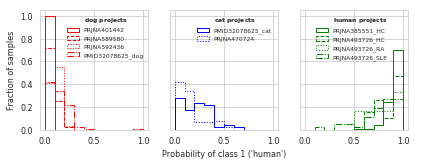

In [60]:
# 2) by host 2
from matplotlib.patches import Rectangle
scores2 = h2['Genus_MW-FDR']
bins = np.linspace(0,1,11)
fig,axes = plt.subplots(1,3,figsize=(6.6,2.2),sharey=True,sharex=True)
plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
sns.set_style("whitegrid")
empty = Rectangle((0,0), 1, 1, fill=False, edgecolor='none',visible=False)
style = {}
style['dog'] = {'PRJNA401442_dog':('r','solid'),'PRJNA589580_dog':('r','dashed'),'PRJNA592436_dog':('r','dotted'),
         'PMID32078625_dog':('r','dashdot')}
style['cat'] = {'PMID32078625_cat':('b','solid'),'PRJNA470724_cat':('b','dotted')}
style['human'] = {'PRJNA385551_HC':('g','solid'),'PRJNA493726_HC':('g','dashed'),
        'PRJNA493726_RA':('g','dotted'),'PRJNA493726_SLE':('g','dashdot')}
hosts = ['dog','cat','human']
for i in range(len(hosts)):
    style_dict = style[hosts[i]]
    for k in style_dict.keys():
        k_scores = scores2[k]
        weights = np.ones_like(k_scores) / len(k_scores)
        axes[i].hist(k_scores,bins=bins,color=style_dict[k][0],weights=weights,histtype='step',linestyle=style_dict[k][1],label=k)
        handles,labels = axes[i].get_legend_handles_labels()
        if (hosts[i]=='human'):
            li=0.1
        else:
            li=0.2
            for j in range(len(labels)):
                if not (labels[j] in ['PMID32078625_dog','PMID32078625_cat']):
                    labels[j] = labels[j].split('_')[0]
        handles2 = [empty]+handles
        labels2 = [r'$\bf{'+hosts[i]+' \ projects}$']+labels
        axes[i].legend(handles2,labels2,loc = 'upper left',bbox_to_anchor=(li, 1),frameon=False)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(b=None)
plt.xlabel('Probability of class 1 (\'human\')')
plt.ylabel('Fraction of samples')
plt.savefig('pics/Figure4.pdf', dpi = 300, bbox_inches='tight')

## Models accuracy on a mixed class sample

In [61]:
ti = test_data.info
cd = ti[ti.Host_type=='pet']
cd_cats = cd[cd.Host=='Felis catus']
cd_dogs = cd[cd.Host=='Canis familiaris']
humans = ti[(ti.Host_type=='human')]
HC_humans = humans[~humans.project_name2.isin(['PRJNA493726_SLE','PRJNA493726_RA'])]

In [62]:
def test_on_sample(human_df,tf,rf):
    results_list = []
    df = pd.DataFrame()
    bins = np.linspace(0,1,21)
    for i in range(100):
        cd_p_cats = shared_functions.sample_equal_categories_with_replacements(
            cd_cats,50,'project_name2',None,i)
        cd_p_dogs = shared_functions.sample_equal_categories_with_replacements(
            cd_dogs,50,'project_name2',None,i)
        hum_p = shared_functions.sample_equal_categories_with_replacements(
            human_df,100,'project_name2',None,i)
        test_i = pd.concat([cd_p_cats,cd_p_dogs,hum_p])
        taxa_df,chao_df,y = test_data.get_data_from_ind(test_i.index,tf.level,False)
        X = tf.transform_df(taxa_df,chao_df)
        y_predict = rf.predict(X)
        acc = metrics.accuracy_score(y,y_predict)
        pr = metrics.precision_score(y,y_predict)
        recall = metrics.recall_score(y,y_predict)
        f1 = metrics.f1_score(y,y_predict)
        rd = {'acc':acc,'precision':pr,'recall':recall,'f1':f1}
        results_list.append(rd)
    x = pd.DataFrame(results_list)
    m = x.mean()
    st = x.std()
    res = pd.DataFrame.from_dict({'m':m,'s':st})
    res['mean_std'] = res.apply(lambda x: ('%.3f ± %.3f' % (x.m, x.s)),axis=1)
    res.drop(['m','s'],axis=1,inplace=True)
    return(res)

In [63]:
levels = [5]
features = ['all','best_holm','best_fdr']
clr_b = [False,True]
res_list = []
pieces2 = {}
for level,features,clr_b in itertools.product(levels, features, clr_b):
    filename = shared_functions.make_name(level,features,clr_b,True)
    view_name = shared_functions.view_name(level,features,clr_b)
    rf = joblib.load('joblib/'+filename)
    f,chao = bf[(level,features)]
    tf = shared_functions.transformer(bf=f,chao=chao,level=level,clr_b=clr_b)
    all_res = test_on_sample(humans,tf,rf)
    healthy_res = test_on_sample(HC_humans,tf,rf)
    pieces = {'total dataset' : all_res,
              'healthy people dataset' :healthy_res}
    t5 = pd.concat(pieces, axis=1)
    t5.columns = t5.columns.droplevel(1)
    pieces2[view_name] = t5
t5_all = pd.concat(pieces2, axis=1)
t5_all

Genus_ALL                         Genus_ALL_CLR  \
           total dataset healthy people dataset  total dataset   
acc        0.971 ± 0.012          0.988 ± 0.007  0.952 ± 0.014   
precision  0.976 ± 0.014          0.977 ± 0.014  0.939 ± 0.018   
recall     0.965 ± 0.018          1.000 ± 0.000  0.966 ± 0.018   
f1         0.970 ± 0.012          0.988 ± 0.007  0.952 ± 0.014   

                                  Genus_MW-Holm                         \
          healthy people dataset  total dataset healthy people dataset   
acc                0.968 ± 0.010  0.935 ± 0.014          0.982 ± 0.009   
precision          0.941 ± 0.017  0.993 ± 0.009          0.994 ± 0.008   
recall             1.000 ± 0.000  0.877 ± 0.027          0.970 ± 0.016   
f1                 0.970 ± 0.009  0.931 ± 0.016          0.982 ± 0.009   

          Genus_MW-Holm_CLR                          Genus_MW-FDR  \
              total dataset healthy people dataset  total dataset   
acc           0.945 ± 0.016          0.974 ± 0.010  0.971 ± 0.010   
precision     0.978 ± 0.014          0.980 ± 0.013  0.976 ± 0.015   
recall        0.909 ± 0.024          0.969 ± 0.016  0.966 ± 0.016   
f1            0.942 ± 0.017          0.974 ± 0.011  0.971 ± 0.010   

                                 Genus_MW-FDR_CLR                         
          healthy people dataset    total dataset healthy people dataset  
acc                0.988 ± 0.008    0.967 ± 0.012          0.990 ± 0.007  
precision          0.977 ± 0.015    0.981 ± 0.015          0.981 ± 0.014  
recall             1.000 ± 0.000    0.952 ± 0.019          1.000 ± 0.000  
f1                 0.988 ± 0.008    0.966 ± 0.012          0.991 ± 0.007

In [64]:
t5_all.to_csv('results/catsNdogs_SupplementaryTable6.txt',sep='\t')
t5_genus_fdr = t5_all.iloc[:, t5_all.columns.get_level_values(0)=='Genus_MW-FDR']
t5_genus_fdr = t5_genus_fdr.droplevel(0,axis=1)
t5_genus_fdr.to_csv('results/catsNdogs_Table4.txt',sep='\t')

In [ ]:
# def test_on_sample_2(human_df):
#     results_list = []
#     for i in range(100):
#         cd_cats = shared_functions.sample_equal_categories_with_replacements(
#             cd_test_data,200,'project_name2',None,i)
#         hum_p = shared_functions.sample_equal_categories_with_replacements(
#             human_df,200,'project_name2',None,i)
#         #print(cd_p.project_name.value_counts())
#         #print(hum_p.project_name.value_counts())
#         test_data = pd.concat([cd_p,hum_p])
#         test_data.drop('project_name2',axis=1,inplace=True)
#         X,y = tf.transform_df(df=test_data)
#         y_predict = rf.predict(X)
#         acc = metrics.accuracy_score(y,y_predict)
#         pr = metrics.precision_score(y,y_predict)
#         recall = metrics.recall_score(y,y_predict)
#         f1 = metrics.f1_score(y,y_predict)
#         rd = {'acc':acc,'precision':pr,'recall':recall,'f1':f1}
#         results_list.append(rd)
#     x = pd.DataFrame(results_list)
#     m = x.mean()
#     st = x.std()
#     res = pd.DataFrame.from_dict({'mean':m,'std':st})
#     return(res)